# Multimodal Mental Health Companion : Computer Vision Modal EDA, Preprocessing and Training of Baseline ML Classifiers

## Submitted by : Kewal Thacker
## Registration Number : 230968126
## Class : DSE 5th Sem Section A, Lab Batch : A1

# Metadata
## Dataset used : FER 2013 (Facial Emotion Recognition Dataset)
## Images : 35886 Photos (48 x 48 pixels, close ups of human faces, grey scaled)
## 7 Classes : Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise
### Source : https://www.kaggle.com/datasets/msambare/fer2013

### Importing Required Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Loading Data and Obtaining Class-Wise Distribution for Train and Test Sets


Training set image counts per class:
angry: 3995
disgust: 436
fear: 4097
happy: 7215
neutral: 4964
sad: 4830
surprise: 3171
Total Training images: 28708

Test set image counts per class:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831
Total Test images: 7178


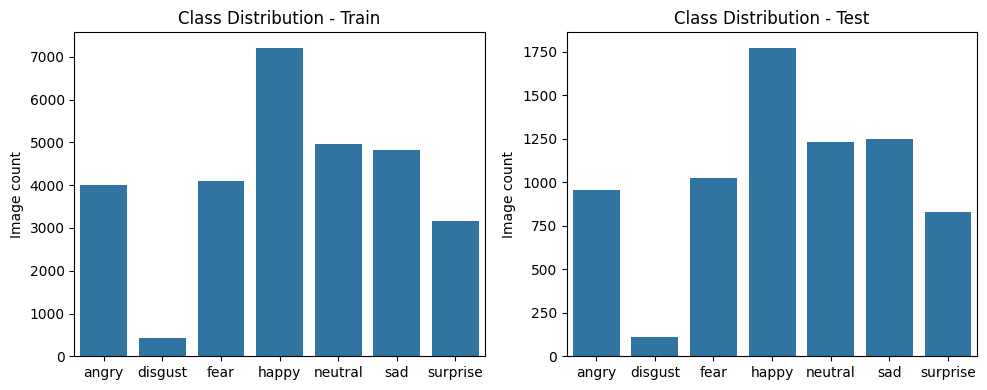

In [3]:
BASE_DIR = "data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")
IMG_HEIGHT, IMG_WIDTH = 48, 48
CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))

def count_images_per_class(data_dir):
    stats = {
        cls: len(os.listdir(os.path.join(data_dir, cls))) 
        for cls in CLASS_NAMES
    }
    return stats

train_counts = count_images_per_class(TRAIN_DIR)
test_counts = count_images_per_class(TEST_DIR)

def print_class_counts(stats, setname):
    print(f"\n{setname} set image counts per class:")
    for cls in CLASS_NAMES:
        print(f"{cls}: {stats[cls]}")
    print(f"Total {setname} images: {sum(stats.values())}")

print_class_counts(train_counts, 'Training')
print_class_counts(test_counts, 'Test')

# Plot class distributions
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Class Distribution - Train")
plt.ylabel("Image count")
plt.subplot(1,2,2)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title("Class Distribution - Test")
plt.ylabel("Image count")
plt.tight_layout()
plt.show()

### Inference : A slight class imbalance exists for the 'disgust' class, however it can be addressed using oversampling techniques such as SMOTE, and it does not affect our objective since out of the clasess, only 'fear' and 'sad' are primarily important from a mental health perspective, and 'anger' can also be consider of secondary importance. All those classes are present in the dataset in a balanced amount

## Loading a few images and labels for visualization of samples

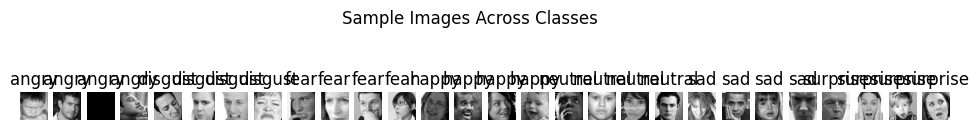

In [4]:
def load_images_and_labels(data_dir, max_per_class=None):
    images, labels = [], []
    for label in CLASS_NAMES:
        class_folder = os.path.join(data_dir, label)
        files = os.listdir(class_folder)
        if max_per_class is not None:
            files = files[:max_per_class]
        for fname in files:
            # Load image and ensure correct shape
            img_path = os.path.join(class_folder, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load a small initial sample for exploratory visualization
sample_images, sample_labels = load_images_and_labels(TRAIN_DIR, max_per_class=4)

plt.figure(figsize=(12,2))
for i in range(len(sample_images)):
    plt.subplot(1, len(sample_images), i+1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(sample_labels[i])
    plt.axis('off')
plt.suptitle('Sample Images Across Classes')
plt.show()


## Label Encoding classes, and performing image data augmentation using the albumentations library


Class weights for training:
angry: 1.03
disgust: 9.41
fear: 1.00
happy: 0.57
neutral: 0.83
sad: 0.85
surprise: 1.29


c:\Users\Kewal\OneDrive\Desktop\FER-2013-Project\.venv\Lib\site-packages\albumentations\augmentations\blur\functional.py:231: UserWarning: blur_limit: Invalid kernel size range (3, 2). Values less than 3 are not allowed. Range automatically adjusted to (3, 3).
  result = _ensure_min_value(result, min_value, info.field_name)
c:\Users\Kewal\OneDrive\Desktop\FER-2013-Project\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


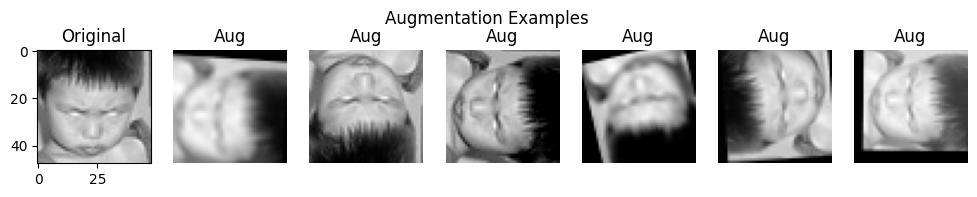

In [7]:
from sklearn.utils.class_weight import compute_class_weight

label_encoder = LabelEncoder()
all_labels = []
for cls in CLASS_NAMES:
    all_labels.extend([cls] * train_counts[cls])
encoded_labels = label_encoder.fit_transform(all_labels)

# Use np.array for classes and keyword arguments
class_weights_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.array(CLASS_NAMES),
    y=all_labels
)
class_weights = dict(zip(CLASS_NAMES, class_weights_vals))

print("\nClass weights for training:")
for cls, weight in class_weights.items():
    print(f"{cls}: {weight:.2f}")

import albumentations as A

augmenter = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(blur_limit=2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.9)
])

img_sample = sample_images[0]
augmented_images = [augmenter(image=img_sample)['image'] for _ in range(6)]

plt.figure(figsize=(12,2))
plt.subplot(1,7,1)
plt.imshow(img_sample, cmap='gray')
plt.title('Original')
for idx, aug_img in enumerate(augmented_images):
    plt.subplot(1,7,idx+2)
    plt.imshow(aug_img, cmap='gray')
    plt.title('Aug')
    plt.axis('off')
plt.suptitle('Augmentation Examples')
plt.show()



## Preparing a smaller dataset to train baseline ML models to evaluate necessity of using Deep Learning Models

In [8]:
def prepare_ml_dataset(data_dir, max_per_class=500):
    # Limit per-class samples for speed
    images, labels = load_images_and_labels(data_dir, max_per_class=max_per_class)
    images_flat = images.reshape(len(images), -1) / 255.0
    labels_enc = label_encoder.transform(labels)
    return images_flat, labels_enc

X_train_ml, y_train_ml = prepare_ml_dataset(TRAIN_DIR, max_per_class=500)
X_test_ml, y_test_ml = prepare_ml_dataset(TEST_DIR, max_per_class=150)

print(f"\nShape of ML train data: {X_train_ml.shape}")
print(f"Shape of ML test data: {X_test_ml.shape}")


Shape of ML train data: (3436, 2304)
Shape of ML test data: (1011, 2304)


## Running and Evaluating ML models


Training SVM...
SVM Accuracy: 0.2730
SVM Classification Report:
              precision    recall  f1-score   support

       angry       0.16      0.19      0.17       150
     disgust       0.36      0.56      0.44       111
        fear       0.22      0.21      0.21       150
       happy       0.34      0.34      0.34       150
     neutral       0.27      0.20      0.23       150
         sad       0.21      0.20      0.20       150
    surprise       0.37      0.29      0.33       150

    accuracy                           0.27      1011
   macro avg       0.28      0.28      0.27      1011
weighted avg       0.27      0.27      0.27      1011



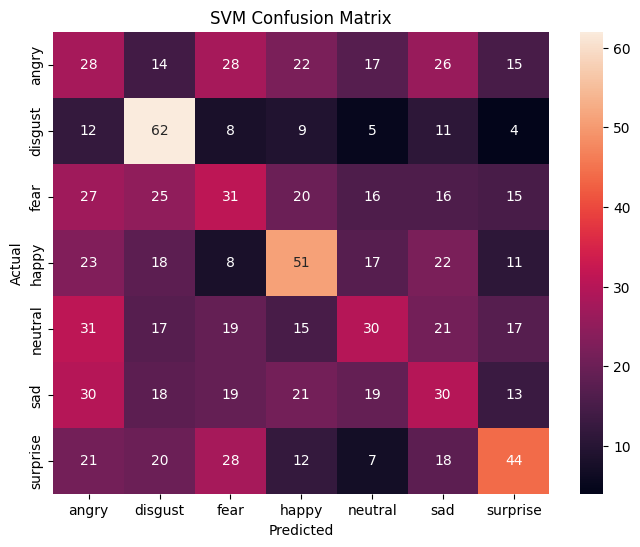

Fear class recall: 0.2067
Sad class recall: 0.2000

Training Random Forest...
Random Forest Accuracy: 0.2938
Random Forest Classification Report:
              precision    recall  f1-score   support

       angry       0.20      0.15      0.17       150
     disgust       0.44      0.54      0.48       111
        fear       0.21      0.15      0.17       150
       happy       0.26      0.28      0.27       150
     neutral       0.24      0.21      0.23       150
         sad       0.23      0.25      0.24       150
    surprise       0.41      0.54      0.47       150

    accuracy                           0.29      1011
   macro avg       0.28      0.30      0.29      1011
weighted avg       0.28      0.29      0.28      1011



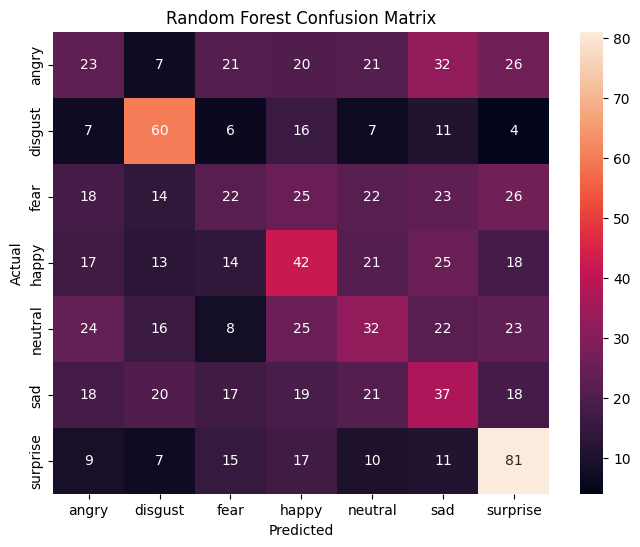

Fear class recall: 0.1467
Sad class recall: 0.2467

Training XGBoost...


c:\Users\Kewal\OneDrive\Desktop\FER-2013-Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:05:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.3343
XGBoost Classification Report:
              precision    recall  f1-score   support

       angry       0.24      0.23      0.24       150
     disgust       0.50      0.51      0.51       111
        fear       0.18      0.15      0.16       150
       happy       0.42      0.39      0.40       150
     neutral       0.28      0.31      0.29       150
         sad       0.30      0.28      0.29       150
    surprise       0.43      0.52      0.47       150

    accuracy                           0.33      1011
   macro avg       0.33      0.34      0.34      1011
weighted avg       0.33      0.33      0.33      1011



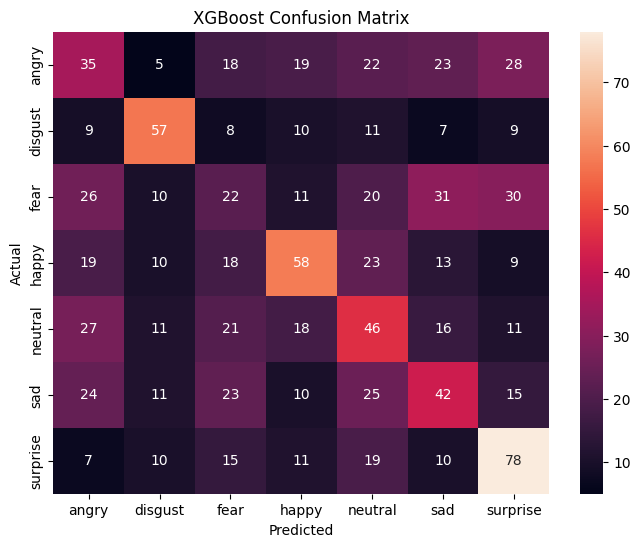

Fear class recall: 0.1467
Sad class recall: 0.2800


In [9]:
def run_and_evaluate_ml_model(model, X_train, y_train, X_test, y_test, modelname):
    print(f"\nTraining {modelname}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{modelname} Accuracy: {acc:.4f}")

    print(f"{modelname} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'{modelname} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Emphasis on 'fear' and 'sad'
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    fear_recall = report.get('fear', {}).get('recall', None)
    sad_recall = report.get('sad', {}).get('recall', None)
    print(f"Fear class recall: {fear_recall:.4f}")
    print(f"Sad class recall: {sad_recall:.4f}")

# SVM (linear kernel for speed)
svm = SVC(kernel='linear', class_weight='balanced', random_state=42)
run_and_evaluate_ml_model(svm, X_train_ml, y_train_ml, X_test_ml, y_test_ml, "SVM")

# Random Forest
rf = RandomForestClassifier(class_weight='balanced', n_estimators=30, max_depth=10, random_state=42)
run_and_evaluate_ml_model(rf, X_train_ml, y_train_ml, X_test_ml, y_test_ml, "Random Forest")

# XGBoost
xgb = XGBClassifier(
    n_estimators=30, max_depth=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42
)
run_and_evaluate_ml_model(xgb, X_train_ml, y_train_ml, X_test_ml, y_test_ml, "XGBoost")

### Inference : All 3 ML classifiers give a poor performance even after extensive pre-processing, which is expected for an image dataset and highlights the need of using Deep Learning Models. The main target classes 'fear' and 'sad' aren't recognized appropriately, as highlighted by their low recall and other metrics in the classification report. The low recall is particularly concerning, since In mental health classification, recall is critical because it measures how well the model identifies true cases of fear and sadness. A low recall means many at-risk individuals go undetected (false negatives), which is far more harmful than occasional false alarms. This underlines why stronger models, like deep learning, are needed to reduce missed cases and enable timely support.